## Author: Paweł Jelonek <br> Date: 30.05.2021
### Machine learning course:<br> Lecture 4 - Classification

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.neighbors import KernelDensity

# plt.rcParams["figure.figsize"]=(20, 10)

Proszę opracować paradygmaty uczenia nienadzorowanego:
1.	klasteryzacja
2.	szacowanie gęstości rozkładu (kernel density estimation)
3.	detekcja wartości odstających

Inżynieria cech:
4.	metody selekcji cech
5.	zmniejszanie wymiarowości danych

Proszę opracować paradygmaty uczenia zespołowego:
6.	bagging
7.	boosting
8.	lasy losowe

W ramach danego paradygmatu uczenia przedstawić:
-	podstawy teoretyczne (krótko)
-	metody/typy
-   parametry, regularyzację, optymalizację
-	implementację (własną lub biblioteczną): uczenie, predykcja (testowanie)
-	typowe metryki wraz z metodami ich wyliczania
-	wizualizację: zbioru/modelu
-	uczenie na wybranym zbiorze danych (przy wielu metodach w ramach paradygmatu, na różnych zbiorach danych)

### 1.  klasteryzacja

### podstawy teoretycznie
Metoda klastrowania k-średnich to nienadzorowana technika uczenia maszynowego wykorzystywana do identyfikowania
klastrów obiektów danych w zestawie danych. Istnieje wiele różnych rodzajów metod grupowania, ale k-średnie jest
jedną z najstarszych i najbardziej przystępnych. Te cechy sprawiają, że implementacja klastrów k-średnich w Pythonie
jest dość prosta, nawet dla początkujących programistów i analityków danych.

In [57]:
def k_means_clustering(x: np.ndarray, y: np.ndarray, title: str):
    plt.scatter(x[:,0], x[:,1], c=y, cmap='gist_rainbow')
    plt.xlabel('{} Length'.format(title), fontsize=18)
    plt.ylabel('{} Width'.format(title), fontsize=18)
    km = KMeans(n_clusters = 3, random_state=1)
    km.fit(x)
    #this will tell us to which cluster does the data observations belong.
    new_labels = km.labels_
    # Plot the identified clusters and compare with the answers
    fig, axes = plt.subplots(1, 2, figsize=(16,8))
    plot_k_means(x[:, 0], x[:, 1], y, axes, title ,'Actual', 'gist_rainbow', 0)
    plot_k_means(x[:, 0], x[:, 1], new_labels, axes, title , 'Predicted', 'jet', 1)
    plt.show()

In [58]:
def plot_k_means(x: np.ndarray, y: np.ndarray, color: np.ndarray, axes: np.ndarray, title: str, result: str, cmap: str, position: int):
    axes[position].scatter(x, y, c=color, cmap=cmap,edgecolor='k', s=150)
    axes[position].set_xlabel('{} length'.format(title), fontsize=18)
    axes[position].set_ylabel('{} width'.format(title), fontsize=18)
    axes[position].tick_params(direction='in', length=10, width=5, colors='k', labelsize=20)
    axes[position].set_title('{}'.format(result), fontsize=18)

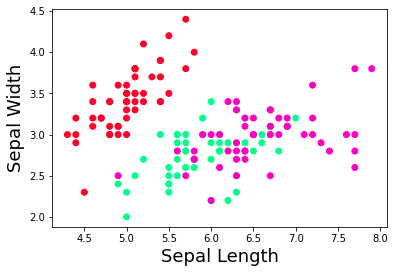

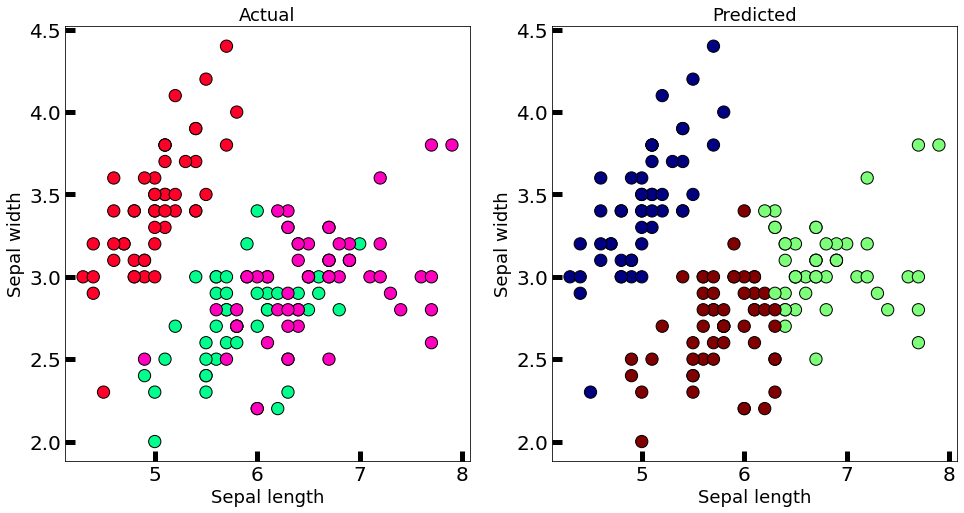

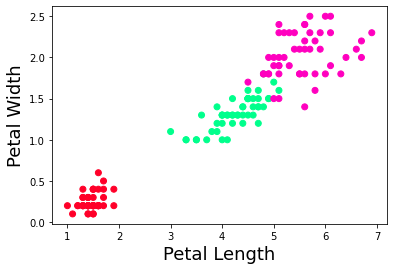

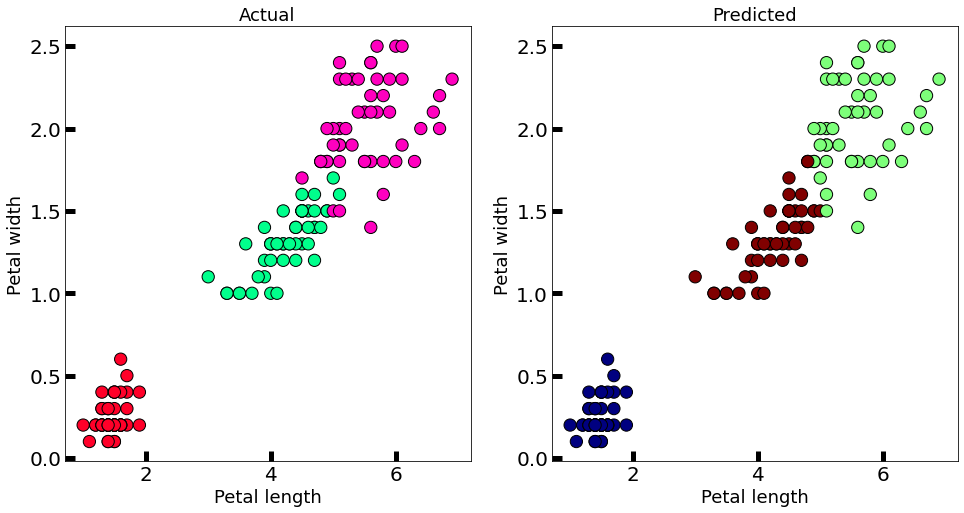

In [59]:
iris = datasets.load_iris()
k_means_clustering(iris.data[:, :2], iris.target, "Sepal")
k_means_clustering(iris.data[:, 2:4], iris.target, "Petal")

### 2.	szacowanie gęstości rozkładu (kernel density estimation)

### 3.	detekcja wartości odstających